In [1]:
import pandas as pd
import numpy as np
import time
import os
from os import listdir
from os.path import isfile, join, basename

import matplotlib.pyplot as plt
import seaborn as sns 

import math
import sys

from lag_features import *
from other_functions import *

import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
DIR = '/Users/carlosperezricardo/Desktop/TFM'

#[10397, 13930, 11298, 11292, 12892]
AIRPORT = 10397
CARRIER = 19393
years_to_load = ['2016','2017','2018','2019']

In [3]:
folder = os.path.join(DIR, 'datasets')
files = [f for f in listdir(folder) if isfile(join(folder, f))]
files = sorted(files)

In [4]:
df = pd.DataFrame()
for file in files:
    loading = []
    if '.zip' in file:
        for year in years_to_load:
            loading.append(year in file)
        output = any(loading)
        if output:
            add_df = pd.read_csv(os.path.join(DIR,'datasets',file), parse_dates=['FL_DATE'])
            add_df = add_df[(add_df.DEST_AIRPORT_ID == AIRPORT) & (add_df.OP_CARRIER_AIRLINE_ID == CARRIER)]
            df = pd.concat([df, add_df], axis=0)
df.reset_index(drop=True, inplace=True)

/Users/carlosperezricardo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29
0,2016-01-01,WN,19393,WN,N697SW,2300,14122,1412202,30198,PIT,...,2005.0,-20.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,WN,19393,WN,N295WN,1045,14492,1449202,34492,RDU,...,1300.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,WN,19393,WN,N410WN,2907,14492,1449202,34492,RDU,...,2035.0,5.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,WN,19393,WN,N7834A,1986,14524,1452401,34524,RIC,...,1242.0,-13.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WN,19393,WN,N553WN,2169,14524,1452401,34524,RIC,...,1943.0,-2.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
df['DEST'].value_counts()

ATL    163301
Name: DEST, dtype: int64

In [7]:
ini_date = datetime.datetime(2016, 1, 1)

train_ini_date = datetime.datetime(2018, 1, 1)
train_fin_date = datetime.datetime(2019, 9, 1)

test_ini_date = datetime.datetime(2019, 9, 1)
test_fin_date = datetime.datetime(2019, 9, 30)

In [8]:
df = df[(df.FL_DATE > ini_date) & (df.FL_DATE <= test_fin_date)]

In [9]:
df.shape

(153903, 30)

In [10]:
# Feature Generation 
df = date_features(df, 'FL_DATE')

In [11]:
# Add flight distance in km
def flight_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = lat1 * math.pi/180
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    
    a = np.sin(delta_phi/2) * np.sin(delta_lambda/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return R * c # in kilometres

In [12]:
airports_df = pd.read_csv(os.path.join('/Users/carlosperezricardo/Desktop/TFM/airlines_airports', 'L_AIRPORT_ID.csv'))
airports_df = airports_df[['Code','Description','City_State','City','State_Country','lat','lon']]

In [13]:
df = pd.merge(df, airports_df[['Code','lat','lon']], left_on='ORIGIN_AIRPORT_ID', right_on='Code')
df.rename({'lat':'lat_ORIGIN','lon':'lon_ORIGIN'}, axis=1, inplace=True)

df = pd.merge(df, airports_df[['Code','lat','lon']], left_on='DEST_AIRPORT_ID', right_on='Code')
df.rename({'lat':'lat_DEST','lon':'lon_DEST'}, axis=1, inplace=True)

In [14]:
df['flight_distance'] = flight_distance(df['lat_ORIGIN'], df['lon_ORIGIN'], df['lat_DEST'], df['lon_DEST'])

/Users/carlosperezricardo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# Add weather
WEATHER_DIR = '/Users/carlosperezricardo/Desktop/TFM/weather'
weather_df = pd.read_csv(os.path.join(WEATHER_DIR, 'weather.csv'))

In [16]:
iata_code = list(df['DEST'].unique())[0]
iata_code

'ATL'

In [17]:
airports_df = pd.read_csv(os.path.join('/Users/carlosperezricardo/Desktop/TFM/airlines_airports', 'airports.csv'))

airports_code = pd.read_excel(os.path.join('/Users/carlosperezricardo/Desktop/TFM/airlines_airports', 'US_airports.xlsx'), sheet_name='Airports')
airports_code.columns = airports_code.iloc[0]
airports_code = airports_code.iloc[1:]
    
states = pd.read_excel(os.path.join('/Users/carlosperezricardo/Desktop/TFM/airlines_airports', 'US_airports.xlsx'), sheet_name='States')
states.columns = ['state_name','state_acronym']

airports = pd.merge(airports_code, states, left_on='City', right_on='state_name', how='left')

airports[['state_name','state_acronym']] = airports[['state_name','state_acronym']].ffill(axis = 0)
airports = airports[~airports['FAA'].isnull()]

In [18]:
icao_code = list(airports[airports.IATA == iata_code]['ICAO'])[0]
icao_code

'KATL'

In [19]:
weather_df = weather_df[weather_df.ICAO == icao_code]
weather_df['Day'] = pd.to_datetime(weather_df['Day'])
weather_df.head()

,Unnamed: 0,Day,Temperature_Max,Temperature_Avg,Temperature_Min,Dew Point_Max,Dew Point_Avg,Dew Point_Min,Humidity_Max,Humidity_Avg,Humidity_Min,Wind Speed_Max,Wind Speed_Avg,Wind Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation,ICAO
85792,85792,2019-01-01,59,53.8,49,53,49.0,44,93,84.3,69,9.0,5.4,0.0,29.1,29.1,28.9,0.00,KATL
85793,85793,2019-01-02,55,53.1,50,53,50.6,49,96,91.3,86,14.0,4.6,0.0,29.0,28.9,28.9,0.60,KATL
85794,85794,2019-01-03,66,55.8,45,58,50.7,37,97,83.8,58,25.0,10.9,3.0,28.9,28.7,28.6,1.00,KATL
85795,85795,2019-01-04,59,49.0,44,38,36.4,34,79,63.3,41,21.0,14.2,7.0,29.0,28.9,28.7,0.56,KATL
85796,85796,2019-01-05,69,54.5,43,41,38.2,36,80,56.7,33,10.0,6.6,0.0,29.1,29.1,29.0,0.00,KATL


In [20]:
df = pd.merge(df, weather_df, left_on='FL_DATE', right_on='Day', how='left')

In [21]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,Humidity_Avg,Humidity_Min,Wind Speed_Max,Wind Speed_Avg,Wind Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation,ICAO
0,2016-01-02,WN,19393,WN,N624SW,6075,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,WN,19393,WN,N762SW,6482,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,WN,19393,WN,N274WN,4005,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-03,WN,19393,WN,N422WN,4617,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-04,WN,19393,WN,N476WN,472,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.groupby('TAIL_NUM')['ARR_DELAY'].apply(lambda x: x.shift(1))

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
153898   -15.0
153899    12.0
153900   -21.0
153901   -10.0
153902     6.0
Name: ARR_DELAY, Length: 153903, dtype: float64

In [23]:
df.shape

(153903, 62)

In [24]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,Humidity_Avg,Humidity_Min,Wind Speed_Max,Wind Speed_Avg,Wind Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation,ICAO
0,2016-01-02,WN,19393,WN,N624SW,6075,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,WN,19393,WN,N762SW,6482,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,WN,19393,WN,N274WN,4005,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-03,WN,19393,WN,N422WN,4617,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-04,WN,19393,WN,N476WN,472,10423,1042302,30423,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 29',
       'month', 'day', 'year', 'FL_DATE_quarter', 'weekday', 'year_month',
       'Code_x', 'lat_ORIGIN', 'lon_ORIGIN', 'Code_y', 'lat_DEST', 'lon_DEST',
       'flight_distance', 'Unnamed: 0', 'Day', 'Temperature_Max',
       'Temperature_Avg', 'Temperature_Min', 'Dew Point_Max', 'Dew Point_Avg',
       'Dew Point_Min', 'Humidity_Max', 'Humidity_Avg', 'Humidity_Min',
       'Wind Speed_Max', 'Wind Speed_Avg', 'Wind Speed_Min

In [26]:
train_df = df[(df.FL_DATE > datetime.datetime(2018, 1, 1)) & (df.FL_DATE <= datetime.datetime(2019, 9, 1))]
test_df = df[(df.FL_DATE > datetime.datetime(2019, 9, 1)) & (df.FL_DATE <= datetime.datetime(2019, 9, 30))]

In [27]:
print(train_df.shape)
print(test_df.shape)

(69479, 62)
(3036, 62)


In [28]:
df_ = df.copy(deep=True)

In [29]:
df_ = df_[(df_.CANCELLED != 1) & (df_.DIVERTED != 1)]

In [30]:
df_['ARR_DELAY_'] = df_['ARR_DELAY'] > 15
df_['DEP_DELAY_'] = df_['DEP_DELAY'] > 15

df_.loc[df.DEP_DELAY<0,'DEP_DELAY'] = 0
df_.loc[df.ARR_DELAY<0,'ARR_DELAY'] = 0

In [31]:
s1 = 14
s2 = 28
s3 = 365

s1 = 7
s2 = 14
s3 = 365

In [32]:
# Lag features by: TAIL_NUM
calculations = {}
calculations['calc1'] = {'gb_list':['TAIL_NUM','FL_DATE'],'target':'ARR_DELAY','shifts':[s1], 'windows':[3,5,10], 'funs':['mean']}
#calculations['calc1'] = {'gb_list':['TAIL_NUM','FL_DATE'],'target':'ARR_DELAY','shifts':[30,45,60], 'windows':[10], 'funs':['mean','std']}
#calculations['calc2'] = {'gb_list':['TAIL_NUM','FL_DATE'],'target':'ARR_DELAY','shifts':[365], 'windows':[5,10], 'funs':['mean']}

df_ = apply_calc(df_, calculations)

In [ ]:
# Lag features by: DEST_AIRPORT_ID
calculations = {}
calculations['calc3'] = {'gb_list':['FL_DATE'],'target':'ARR_DELAY_','shifts':[s1,s2], 'windows':[1,5,10], 'funs':['mean','std']}
calculations['calc4'] = {'gb_list':['FL_DATE'],'target':'ARR_DELAY','shifts':[s1,s2], 'windows':[1,15,30], 'funs':['median','std']}
calculations['calc5'] = {'gb_list':['FL_DATE'],'target':'ARR_DELAY_','shifts':[s3], 'windows':[10], 'funs':['mean','std']}

df_ = apply_calc(df_, calculations)

Generating ARR_DELAY__FL_DATE_s7_r1_mean
Generating ARR_DELAY__FL_DATE_s14_r1_mean
Generating ARR_DELAY__FL_DATE_s7_r5_mean
Generating ARR_DELAY__FL_DATE_s14_r5_mean
Generating ARR_DELAY__FL_DATE_s7_r10_mean
Generating ARR_DELAY__FL_DATE_s14_r10_mean
Generating ARR_DELAY__FL_DATE_s7_r1_std
Generating ARR_DELAY__FL_DATE_s14_r1_std
Generating ARR_DELAY__FL_DATE_s7_r5_std
Generating ARR_DELAY__FL_DATE_s14_r5_std
Generating ARR_DELAY__FL_DATE_s7_r10_std
Generating ARR_DELAY__FL_DATE_s14_r10_std
Generating ARR_DELAY_FL_DATE_s7_r1_median
Generating ARR_DELAY_FL_DATE_s14_r1_median
Generating ARR_DELAY_FL_DATE_s7_r15_median
Generating ARR_DELAY_FL_DATE_s14_r15_median
Generating ARR_DELAY_FL_DATE_s7_r30_median
Generating ARR_DELAY_FL_DATE_s14_r30_median
Generating ARR_DELAY_FL_DATE_s7_r1_std
Generating ARR_DELAY_FL_DATE_s14_r1_std
Generating ARR_DELAY_FL_DATE_s7_r15_std
Generating ARR_DELAY_FL_DATE_s14_r15_std
Generating ARR_DELAY_FL_DATE_s7_r30_std
Generating ARR_DELAY_FL_DATE_s14_r30_std
Gene

In [ ]:
# Lag features by: ORIGIN_AIRPORT_ID
calculations = {}
calculations['calc6'] = {'gb_list':['ORIGIN_AIRPORT_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s1,s2], 'windows':[1,5,10], 'funs':['mean']}
calculations['calc7'] = {'gb_list':['DEST_AIRPORT_ID','FL_DATE'],'target':'DEP_DELAY','shifts':[s1,s2], 'windows':[1,15,30], 'funs':['median','std']}
calculations['calc8'] = {'gb_list':['ORIGIN_AIRPORT_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s3], 'windows':[10], 'funs':['mean']}

df_ = apply_calc(df_, calculations)

Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s7_r1_mean
Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s14_r1_mean
Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s7_r5_mean
Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s14_r5_mean
Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s7_r10_mean
Generating DEP_DELAY__ORIGIN_AIRPORT_ID_FL_DATE_s14_r10_mean
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r1_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s14_r1_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r15_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s14_r15_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r30_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s14_r30_median
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r1_std
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s14_r1_std
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r15_std
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s14_r15_std
Generating DEP_DELAY_DEST_AIRPORT_ID_FL_DATE_s7_r30_std
Genera

In [ ]:
# Lag features by: OP_CARRIER_AIRLINE_ID
calculations = {}
calculations['calc3'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY_','shifts':[s1,s2], 'windows':[1,5,10], 'funs':['mean']}
calculations['calc4'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY','shifts':[s2], 'windows':[10], 'funs':['median','std']}
calculations['calc5'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY_','shifts':[s3], 'windows':[10], 'funs':['mean']}

calculations['calc3'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s1,s2], 'windows':[1,5,10], 'funs':['mean']}
calculations['calc4'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY','shifts':[s1], 'windows':[10], 'funs':['median','std']}
calculations['calc5'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s3], 'windows':[10], 'funs':['mean']}

df_ = apply_calc(df_, calculations)

Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_r1_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s14_r1_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_r5_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s14_r5_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_r10_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s14_r10_mean
Generating DEP_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_r10_median
Generating DEP_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_r10_std
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s365_r10_mean


In [ ]:
# Convert times 
# [ARR_TIME, DEP_TIME]

df_['DEP_TIME'] = df_['DEP_TIME']/100
df_['ARR_TIME'] = df_['ARR_TIME']/100

df_['DEP_TIME'] = df_['DEP_TIME'].astype(int)
df_['ARR_TIME'] = df_['ARR_TIME'].astype(int)

In [ ]:
df_['TAIL_NUM_n_flights'] = df_.groupby(['TAIL_NUM','FL_DATE'])['ARR_TIME'].transform( lambda x: x.count())

In [ ]:
df_['OP_CARRIER_AIRLINE_ID_n_flights'] = df_.groupby(['OP_CARRIER_AIRLINE_ID','FL_DATE'])['ARR_TIME'].transform( lambda x: x.count())

In [ ]:
df_['DEP_n_flights_per_hour'] = df_.groupby(['FL_DATE','DEP_TIME'])['ARR_TIME'].transform( lambda x: x.count())
df_['ARR_n_flights_per_hour'] = df_.groupby(['FL_DATE','ARR_TIME'])['DEP_TIME'].transform( lambda x: x.count())

df_['n_flights_per_hour'] = df_['DEP_n_flights_per_hour'] + df_['ARR_n_flights_per_hour'] 

In [ ]:
df_['DEP_n_flights_cumsum'] = df_.groupby(['FL_DATE'])['DEP_n_flights_per_hour'].transform( lambda x: x.cumsum())
df_['ARR_n_flights_cumsum'] = df_.groupby(['FL_DATE'])['ARR_n_flights_per_hour'].transform( lambda x: x.cumsum())
df_['n_flights_cumsum'] = df_.groupby(['FL_DATE'])['n_flights_per_hour'].transform( lambda x: x.cumsum())

In [ ]:
# Not Lagged
calculations = {}
calculations['calc1'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY_','shifts':[s1], 'funs':['mean','std']}
calculations['calc2'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY','shifts':[s1], 'funs':['mean','std']}

calculations['calc3'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'ARR_DELAY_','shifts':[s3], 'funs':['mean','std']}

calculations['calc4'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s1], 'funs':['mean','std']}
calculations['calc5'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY','shifts':[s1], 'funs':['mean','std']}

calculations['calc6'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'DEP_DELAY_','shifts':[s3], 'funs':['mean','std']}

df_ = apply_calc(df_, calculations)

Generating ARR_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating ARR_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_std
Generating ARR_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating ARR_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_std
Generating ARR_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s365_mean
Generating ARR_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s365_std
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s7_std
Generating DEP_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating DEP_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_std
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s365_mean
Generating DEP_DELAY__OP_CARRIER_AIRLINE_ID_FL_DATE_s365_std


In [ ]:
# Type of delay
calculations = {}
calculations['calc3'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'CARRIER_DELAY','shifts':[s1], 'funs':['mean']}
calculations['calc4'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'LATE_AIRCRAFT_DELAY','shifts':[s1], 'funs':['median']}
calculations['calc5'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'NAS_DELAY','shifts':[s1], 'funs':['mean']}
calculations['calc6'] = {'gb_list':['FL_DATE'],'target':'WEATHER_DELAY','shifts':[s1], 'funs':['mean']}
calculations['calc7'] = {'gb_list':['OP_CARRIER_AIRLINE_ID','FL_DATE'],'target':'LATE_AIRCRAFT_DELAY','shifts':[s1], 'funs':['mean']}

calculations['calc8'] = {'gb_list':['ORIGIN_AIRPORT_ID'],'target':'WEATHER_DELAY','shifts':[s1], 'funs':['mean']}
calculations['calc9'] = {'gb_list':['ORIGIN_AIRPORT_ID'],'target':'NAS_DELAY','shifts':[s1], 'funs':['mean']}

df_ = apply_calc(df_, calculations)

Generating CARRIER_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating LATE_AIRCRAFT_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_median
Generating NAS_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating WEATHER_DELAY_FL_DATE_s7_mean
Generating LATE_AIRCRAFT_DELAY_OP_CARRIER_AIRLINE_ID_FL_DATE_s7_mean
Generating WEATHER_DELAY_ORIGIN_AIRPORT_ID_s7_mean
Generating NAS_DELAY_ORIGIN_AIRPORT_ID_s7_mean


In [ ]:
calculations = {}
calculations['calc'] = {'gb_list':['FL_DATE'],'target':'ARR_DELAY','shifts':[s1, s2, s3+s1], 'windows':[1,7,14], 'funs':['mean','std']}

df_ = apply_calc(df_, calculations)

Generating ARR_DELAY_FL_DATE_s7_r1_mean
Generating ARR_DELAY_FL_DATE_s14_r1_mean
Generating ARR_DELAY_FL_DATE_s372_r1_mean
Generating ARR_DELAY_FL_DATE_s7_r7_mean
Generating ARR_DELAY_FL_DATE_s14_r7_mean
Generating ARR_DELAY_FL_DATE_s372_r7_mean
Generating ARR_DELAY_FL_DATE_s7_r14_mean
Generating ARR_DELAY_FL_DATE_s14_r14_mean
Generating ARR_DELAY_FL_DATE_s372_r14_mean
Generating ARR_DELAY_FL_DATE_s7_r1_std
Generating ARR_DELAY_FL_DATE_s14_r1_std
Generating ARR_DELAY_FL_DATE_s372_r1_std
Generating ARR_DELAY_FL_DATE_s7_r7_std
Generating ARR_DELAY_FL_DATE_s14_r7_std
Generating ARR_DELAY_FL_DATE_s372_r7_std
Generating ARR_DELAY_FL_DATE_s7_r14_std
Generating ARR_DELAY_FL_DATE_s14_r14_std
Generating ARR_DELAY_FL_DATE_s372_r14_std


In [ ]:
drop_cols = ['CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 29']
for col in drop_cols:
    del df_[col]

In [ ]:
keep = list(df_.select_dtypes(include=np.number).columns)

for col in df_.select_dtypes(exclude=np.number).columns:
    print(col, len(df_[col].unique()))
    if len(df_[col].unique()) < 100:
        keep.append(col)
        le = LabelEncoder()
        df_[col] = le.fit_transform(df_[col])
        df_[col] = df_[col].astype('category')

FL_DATE 1338
OP_UNIQUE_CARRIER 1
OP_CARRIER 1
TAIL_NUM 873
ORIGIN 40
ORIGIN_CITY_NAME 39
ORIGIN_STATE_ABR 24
DEST 1
DEST_CITY_NAME 1
DEST_STATE_ABR 1
year_month 44
Day 274
ICAO 2
ARR_DELAY_ 2
DEP_DELAY_ 2


In [ ]:
drop_cols = ['DEST_CITY_NAME','ORIGIN_CITY_NAME', 'Unnamed: 0','year_month']

for col in drop_cols:
    try:
        keep.remove(col)
    except:
        pass


In [ ]:
df_.fillna(0, inplace=True)

In [ ]:
df_.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,ARR_DELAY_FL_DATE_s7_r14_mean,ARR_DELAY_FL_DATE_s14_r14_mean,ARR_DELAY_FL_DATE_s372_r14_mean,ARR_DELAY_FL_DATE_s372_r1_std,ARR_DELAY_FL_DATE_s7_r7_std,ARR_DELAY_FL_DATE_s14_r7_std,ARR_DELAY_FL_DATE_s372_r7_std,ARR_DELAY_FL_DATE_s7_r14_std,ARR_DELAY_FL_DATE_s14_r14_std,ARR_DELAY_FL_DATE_s372_r14_std
0,2016-01-02,0,19393,0,N624SW,6075,10423,1042302,30423,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,0,19393,0,N762SW,6482,10423,1042302,30423,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-03,0,19393,0,N274WN,4005,10423,1042302,30423,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-03,0,19393,0,N422WN,4617,10423,1042302,30423,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-04,0,19393,0,N476WN,472,10423,1042302,30423,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df = df_.loc[(df_.FL_DATE > datetime.datetime(2018, 1, 1)) & (df_.FL_DATE <= datetime.datetime(2019, 9, 1)), keep]
test_df = df_.loc[(df_.FL_DATE > datetime.datetime(2019, 9, 1)) & (df_.FL_DATE <= datetime.datetime(2019, 9, 30)), keep]

In [ ]:
print(train_df.shape)
print(test_df.shape)

(67872, 148)
(2982, 148)


In [ ]:
TARGET = 'ARR_DELAY_'
drop = ['DEP_DELAY','ARR_DELAY','DEP_DELAY_']

In [ ]:
features = [ col for col in train_df.columns if col != TARGET and col not in drop ]

X_train = train_df[features]
y_train = train_df[TARGET]

X_test = test_df[features]
y_test = test_df[TARGET]

In [ ]:
import lightgbm as lgbm
#reg = lgbm.LGBMRegressor(objective='tweedie', n_estimators=400)
reg = lgbm.LGBMClassifier(metric='roc_auc', n_estimators=400)

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = lgbm.LGBMClassifier(metric='roc_auc')

param_dist = {"max_depth": [40, 50, 60, 70],
                  "n_estimators": [250, 300, 450, 550, 650]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='roc_auc', verbose=20)
grid_search.fit(X_train, y_train)
reg = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/carlosperezricardo/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
reg.fit(X_train, y_train)

LGBMClassifier(max_depth=40, metric='roc_auc', n_estimators=250)

In [ ]:
pd.DataFrame({'columns': X_train.columns,'feature_importance':reg.feature_importances_}).sort_values('feature_importance',ascending=False).head(25)

,columns,feature_importance
138,ORIGIN,747
9,ARR_TIME,600
142,year_month,445
1,OP_CARRIER_FL_NUM,403
8,DEP_TIME,335
119,NAS_DELAY_ORIGIN_AIRPORT_ID_s7_mean,213
96,ARR_n_flights_per_hour,194
118,WEATHER_DELAY_ORIGIN_AIRPORT_ID_s7_mean,192
97,n_flights_per_hour,156
14,weekday,141


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, reg.predict_proba(X_train)[:, 1])

0.9442073104338289

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, reg.predict(X_train), digits=6))

              precision    recall  f1-score   support

           0   0.904750  0.991391  0.946091     56107
           1   0.924437  0.502252  0.650878     11765

    accuracy                       0.906604     67872
   macro avg   0.914593  0.746822  0.798485     67872
weighted avg   0.908162  0.906604  0.894919     67872



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, reg.predict(X_train))

array([[55624,   483],
       [ 5856,  5909]])

<AxesSubplot:>

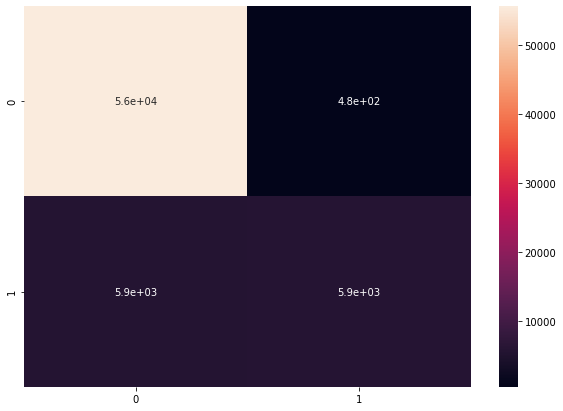

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(y_train, reg.predict(X_train)), annot=True)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, reg.predict(X_test))

array([[2654,   48],
       [ 233,   47]])

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# With SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV


In [ ]:
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)

In [ ]:
print('Before Sampling')
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\n After Sampling')
counter = Counter(y_train_ov)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Before Sampling
Class=0, n=56107 (82.666%)
Class=1, n=11765 (17.334%)

 After Sampling
Class=0, n=56107 (82.666%)
Class=1, n=56107 (82.666%)


In [ ]:
rf = lgbm.LGBMClassifier(metric='roc_auc')

param_dist = {"max_depth": [30, 45, 50],
                  "n_estimators": [150, 200, 250, 300]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='roc_auc', verbose=20)
grid_search.fit(X_train_ov, y_train_ov)
smote_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/carlosperezricardo/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
smote_model = lgbm.LGBMClassifier(metric='roc_auc', n_estimators=300, max_depth=50)
smote_model.fit(X_train_ov, y_train_ov)

LGBMClassifier(max_depth=50, metric='roc_auc', n_estimators=300)

In [ ]:
print(smote_model)
y_pred_train_ = smote_model.predict_proba(X_train_ov)[:, 1]
y_pred_train = smote_model.predict_proba(X_train)[:, 1]
y_pred_test = smote_model.predict_proba(X_test)[:, 1]

print("TRAIN (oversample):", roc_auc_score(y_train_ov, y_pred_train_))
print("TRAIN:", roc_auc_score(y_train, y_pred_train))
print("TEST:", roc_auc_score(y_test, y_pred_test))

LGBMClassifier(max_depth=50, metric='roc_auc', n_estimators=300)
TRAIN (oversample): 0.987448394179683
TRAIN: 0.9415350894677736
TEST: 0.7845233689330654


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, smote_model.predict(X_train))

array([[55377,   730],
       [ 5539,  6226]])